In [29]:
## fetch the data 

import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_data(fetch_url = HOUSING_URL , fetch_path = HOUSING_PATH):
    os.makedirs( fetch_path , exist_ok = True)
    tgz_path = os.path.join(fetch_path ,"housing.tgz")
    urllib.request.urlretrieve(fetch_url , tgz_path)
    data_tgz = tarfile.open(tgz_path)
    data_tgz.extractall(path= fetch_path)
    data_tgz.close()

fetch_data()

In [30]:
import pandas as pd

def load_housing_data(housing_path = HOUSING_PATH):
    csv_file_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_file_path)

data=load_housing_data()

In [31]:
## Eye data lookup
data.head()
data.info()
## well there we have the ocean_proximity here is a categorical attribute
data['ocean_proximity'].value_counts()

## get some stat about the data
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


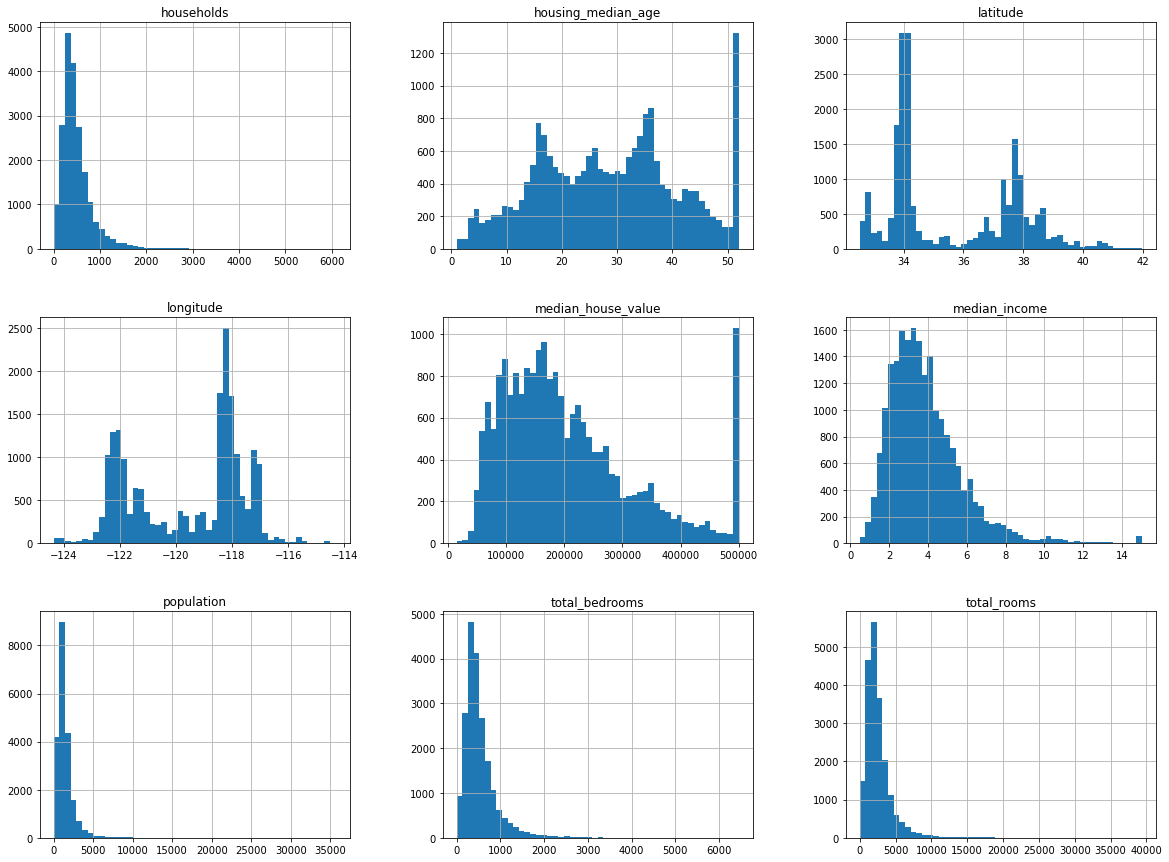

In [32]:
## to have another feel of the type of data we have create histogram for the numerical attr.
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins= 50 , figsize= (20 , 15))
plt.show()
## from these histograms important information can be gathered\
## - it is clear that multiple features have their values capped ,median income for example( though not really significant and
## will not make huge effect but good to know that) , however housing median age and median housing value ( the labeled attribute)
## is capped for a max of 500k , this is a major drawback in the distribution of data as a false pattern will be learnt that 
## there is over 1K discricts with 500K median house value which is indeed not true.
## to handle this you can either ignore any values that are greater than 500K or ask the busniess owners if it is ok that 500K+ will 
## not be as accurate as the whole model

## another thing to observe is that gausiian distributions are not perfect they are skewed towards the the end of the axis this 
## could be tackled in the future.

In [33]:
## train test splitting
from sklearn.model_selection import train_test_split
import numpy as np

## well , this is probably one of the simplist thing that someone can think of while makeing his ML model - just splitting the data.
## it is indeed simple but small details that many people ignore can lead easily to significant sampling bias
## if you are creating a survey about how challenging an engineering degree is , it would be dump if you asked people with an
## avg GPA less than 3 only , just as dump if you are asking students that only got a 3.8+. you need to check how is the GPAs distibuted
## and accordingly decide how many students if each sector you will be asking if 15% scored 3.8+ and 60% scored 3+ 3.8- and the rest 
## were less than a 3 then if you are asking 100 students you need to maintain the same ratios. 
## this is just the same thing when you are samplign your data you dont want a training test with many of any value you just wwant 
## the natural amount of every value. Well in this case it is the income attribute( you don't want more
## wealthy people or more poor ones you want the real dist) that we want to wisly split it
## being a numerical attribute makes this quite challenging we neeed to categorize the data first.
## you can choose the amount of buckets flexibly here 5, 6 or 7 should be enough to represent the data.
data["income_cat"] = pd.cut(data['median_income'], bins=[0, 1.5, 3.0,4.5,6,np.inf], labels = [1 ,2,3,4,5])

train_set , test_set = train_test_split(data , test_size=0.2 , random_state = 42)


In [34]:
## next lets see the original dist of the data
print(data["income_cat"].value_counts()*100 / len(data)) 

print(test_set["income_cat"].value_counts()*100 / len(test_set))
## this data is 20K rows so it might be deciptive to say that percentages are near some values are far by 1% which is great
## now lets try the so called Stratified approach 
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1 , test_size = 0.2 , random_state = 42)
for train_index , test_index in split.split(data , data["income_cat"]):
    train_setStra = data.loc[train_index]
    test_setStra = data.loc[test_index]

print(test_setStra["income_cat"].value_counts()*100 / len(test_set))
## it could be seen that this gives way better results, now remove the extra column
for set_ in ( train_setStra , test_setStra):
    set_.drop("income_cat" , axis=1 , inplace = True)

3    35.058140
2    31.884690
4    17.630814
5    11.443798
1     3.982558
Name: income_cat, dtype: float64
3    35.852713
2    32.437016
4    16.739341
5    10.949612
1     4.021318
Name: income_cat, dtype: float64
3    35.053295
2    31.879845
4    17.635659
5    11.458333
1     3.972868
Name: income_cat, dtype: float64


In [35]:
## Now it is time to make some data visualizations to grasp the correlations between the features , it is usually a good practice
## to work on a copy of the data , if data is Big get some portions of it
## MAKE SURE FROM THIS POINT YOU NEVER LOOK AT THE TEST SET YOUR BRAIN IS WIDLY OPEN TO OVERFITTING IT MUST BE KEPT UNSEEN

train_copy = train_setStra.copy()

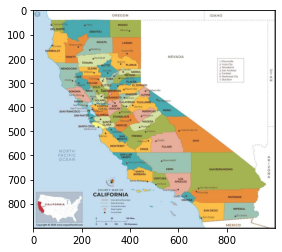

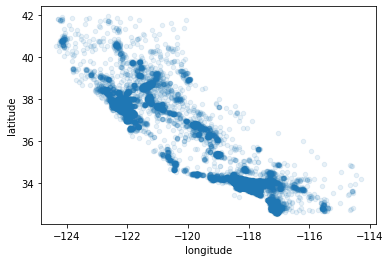

In [42]:
## well lets see the geographical data and how is the districts distributes ( costal ones seem to be very dense)
## alpha param is importnat to see the density of points try removing it to get this 
## why we do this , well it turns out that our brains are super powerful in spotting patterns in images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('imgs/cal.jpg')
imgplot = plt.imshow(img)
train_copy.plot(kind='scatter' , x='longitude' , y='latitude' , alpha=0.1)

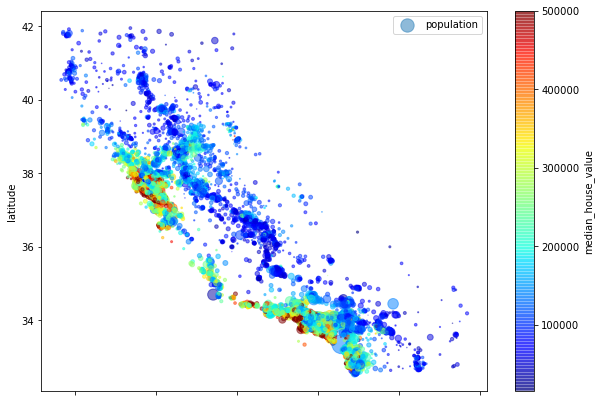

In [48]:
## after validating the user geographical points against the map of california lets check how the population and median house values 
## are corrlelated but first lets visualize it 
## s: circle radius , c= circle color
## here the radius of the circle corresponds to the populatiion 
## and the colir corresponds to the median housing value
## it is very clear that costal regions are more reddish and that's expected beach houses are not cheap!
## and also population there is higher than many others areas , though this is not the case with the northren coastal part

train_copy.plot(kind='scatter' , x='longitude' , y='latitude' , alpha =0.5 ,
               s= train_copy['population']/100 ,label="population", figsize=(10,7) , 
               c="median_house_value" , cmap= plt.get_cmap("jet") , colorbar=True)
plt.legend()